This notebook implements a two trading strategies, "buy and hold" where a stock is bought at the starting of a time interval and sold at the end of the time interval, and another trading strategy "MA5-MA10" where a stock is bought when there is a golden cross and is sold when there is death cross. Annualized volatility, Maximum drawdown and annualized return are calculated and compared for both the trading strtegies.

In [1]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
path = "C:\\Users\\ankita\\jupyter_notebooks\\RA\\txg01012020to06062020.csv"
data_TXG = pd.read_csv(path)
#data_TXG = data_TXG.sort_values(by = ['Date'])

In [3]:
def buy_to_hold(buy):
    
    hold = np.zeros(len(buy))
    signal = 0
    
    for i in range(len(buy)):
        if buy[i] == 1:
            signal = 1
        elif buy[i] == -1:
            signal = 0
        
        hold[i] = signal
    
    return(hold)

def annualized_volatility(val , daily_scale = 252):
    
    perc_daily_change = (np.diff(val)/val[:-1])
    perc_daily_change = perc_daily_change[np.where(perc_daily_change!=0)[0]]
    daily_volatality = np.std(perc_daily_change)
    annual_volatality = daily_volatality*(daily_scale**(1/2))
    
    return(annual_volatality)

def annualized_return(val, daily_scale = 252):
    
    diff = np.diff(val)
    
    buy_time_index = np.where(diff != 0)[0][0]
    sell_time_index = np.where(diff != 0)[0][-1] + 1
    interval = sell_time_index - buy_time_index + 1
    
    buy = val[buy_time_index]
    sell = val[sell_time_index]
    
    return_rate = sell/buy
    
    
    #print(interval)
    #r = (return_rate + 1)**(252/interval) - 1
    r = (return_rate)**(252/interval) - 1
    
    return(r*100)


def MaximumDrawDown(val):
    
    high = val[0]
    low = val[0]
    MDD_max = 0
    
    for i in range(len(val)):
        
        if val[i] > high:
            high = val[i]
            high_changed = i
            low = high
        
        if val[i] < low:
            low = val[i]
        
        
        if high != low:
            MDD = (high - low)/high
            
            if MDD > MDD_max:
                MDD_max = MDD
    
    return(MDD_max*100)


def trade_MA(price, ma_fast = 5, ma_slow = 10):
    
    SMA_5 = price.rolling(window = ma_fast).mean()
    SMA_10 = price.rolling(window = ma_slow).mean()
    
    difference = SMA_5.diff()
    difference_rolling_sum = difference.rolling(window = 7).sum()
    
    #setting up the cross indicator 
    cross_indicator = [ 1 if ((SMA_5[i] <= SMA_10[i] and SMA_5[i+1] >= SMA_10[i+1]) or (SMA_5[i] >= SMA_10[i] and SMA_5[i+1] <= SMA_10[i+1])) else 0 for i in range(len(SMA_5) -1)]
    
    #checking if a cross might have occured in the past
    diff_MA = SMA_5 - SMA_10
    diff_MA = diff_MA[~np.isnan(diff_MA)]
    
    if all(i > 0 for i in diff_MA[:5]) == True or all(i < 0 for i in diff_MA[:5]) == True:
        cross_past = 1
    else:
        cross_past = 0
        
    #setting up the trend indicator
    #1 indicates an upward trend, -1 indicates a downward trend else 0
    trend_indicator = [1 if i > 0 else -1 if i < 0 else 0 for i in difference_rolling_sum]
    
    cross = 0 #indicating if a cross occurred
    trend_changed = 0 #indicating if trend changed direction
    trend_direction = 0 #indicating the direction of trend
    
    buy_sell = np.zeros(len(price)) 
    
    for i in range(len(cross_indicator)):
        
        trend_direction = trend_indicator[i]
        
        #if cross_indicator[i] == 1:
            #cross = 1
        if (i-2) >= 0 and (cross_indicator[i-2] == 1):
            cross = 1
        else:
            cross = 0
            
            
        if (cross == 1 or cross_past == 1) and trend_direction == 1:
            cross_past = 0
            buy_sell[i] = 1
        elif (cross == 1 or cross_past == 1) and trend_direction == -1:
            cross_past = 0
            buy_sell[i] = -1
        
    hold = buy_to_hold(buy_sell)
    
    return(hold)

def trade_buy_hold(time_point_buy, time_point_sell, price):
    
    #time_point_buy - list of all time points when the stock is bought
    #time_point_sell - list of all time points when the stock is sold
    #price - list of prices at all time points
    
    hold = np.zeros(len(price))
    
    for i,j in zip(time_point_buy,time_point_sell):
        hold[i-1:j-1] = 1
    
    return(hold)

def price2invest(hold,price,cash):
    #returns the portfolio for a strategy
    
    portfolio = []
    start = -1 #to indicate the time point when trading began
    
    if hold[0] == 1:
        start = 0
        shares = cash/price[0]
        hold_price = shares*price[0]
    else:
        hold_price = cash
        shares = 0
    
    portfolio.append(hold_price)
    
    for i in range(1,len(hold)):
        
        if hold[i-1] == 0 and hold[i] == 1:
            if start == -1:
                start = i
            shares = cash/price[i]
        
        if hold[i] == 1:
            hold_price = shares*price[i]
            #cash = hold_price
        if hold[i-1] == 1 and hold[i] == 0:
            cash = shares*price[i]
            hold_price = cash
            #hold_price = price[i]
        
        portfolio.append(hold_price)
    
    
    return(portfolio)

In [4]:
price = data_TXG['TXG.Adjusted']
hold_MA = trade_MA(price)
portfolio_MA = np.array(price2invest(hold_MA,price,price[0]))

time_point_buy = [1]
time_point_sell = [len(price)]
hold_buyhold = trade_buy_hold(time_point_buy , time_point_sell, price)
portfolio_buyhold = np.array(price2invest(hold_buyhold,price,price[0]))

#annualized volatility
annualized_volatility_MA = annualized_volatility(portfolio_MA)
annualized_volatility_buyhold = annualized_volatility(portfolio_buyhold)

#annualized return
annualized_return_MA = annualized_return(portfolio_MA)
annualized_return_buyhold = annualized_return(portfolio_buyhold)

#Maximum DrawDown
MDD_MA = MaximumDrawDown(portfolio_MA)
MDD_buyhold = MaximumDrawDown(portfolio_buyhold)




print("Trading Strategy MA")
print("annualized volatility",annualized_volatility_MA)
print("annualized return",annualized_return_MA)
print("maximum drawdown",MDD_MA)
print()
print("Trading Strategy buy hold")
print("annualized volatility",annualized_volatility_buyhold)
print("annualized return",annualized_return_buyhold)
print("maximum drawdown",MDD_buyhold)

Trading Strategy MA
annualized volatility 0.54610608183703
annualized return 140.56747003976108
maximum drawdown 19.76290792898485

Trading Strategy buy hold
annualized volatility 0.6100904447572698
annualized return 33.309177785985234
maximum drawdown 51.63196534518949


Plot for buy and hold trading strategy

In [17]:
len(portfolio_buyhold) == len(data_TXG['Date'])

True

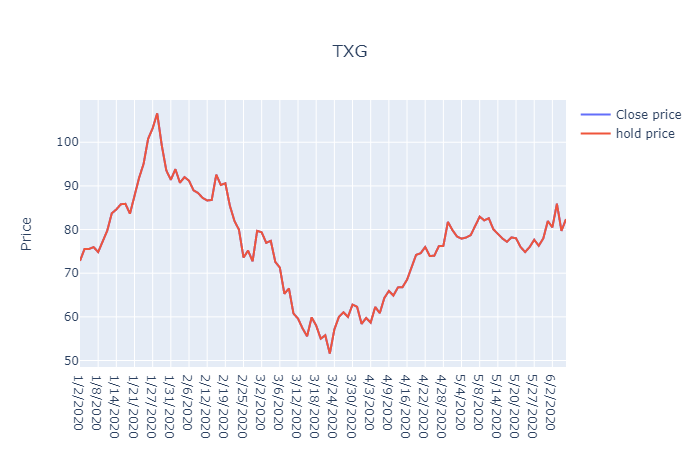

In [5]:
buyhold = pd.DataFrame({'Date':data_TXG['Date'],'TXG.Close':data_TXG['TXG.Close'],'holdingvalue':portfolio_buyhold})

fig = go.Figure()
fig.add_trace(go.Scatter(x = buyhold['Date'], y = buyhold['TXG.Close'], mode = 'lines', name = 'Close price'))
fig.add_trace(go.Scatter(x = buyhold['Date'], y = buyhold['holdingvalue'], mode = 'lines', name = 'hold price'))
fig.update_layout(autosize = False, width = 800, height = 500, yaxis_title = "Price",
                 title={'text': "TXG",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show("png")

Plot of hold value for MA5-MA10 trading strategy 

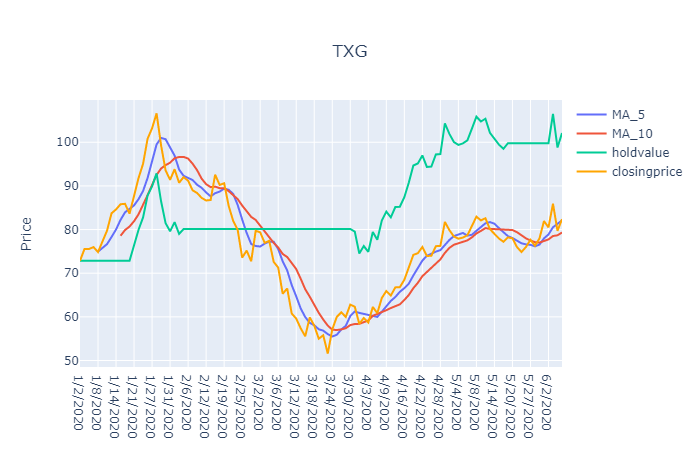

In [6]:
ma_fast = 5
ma_slow = 10
SMA_5 = price.rolling(window = ma_fast).mean()
SMA_10 = price.rolling(window = ma_slow).mean()
MA = pd.DataFrame({'MA_5':SMA_5, 'MA_10':SMA_10,'holdingvalue':portfolio_MA,'Date':data_TXG['Date'],'TXG.close':data_TXG['TXG.Close']})

fig = go.Figure()
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['MA_5'], mode = 'lines', name = 'MA_5'))
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['MA_10'], mode = 'lines', name = 'MA_10'))
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['holdingvalue'], mode = 'lines', name = 'holdvalue'))
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['TXG.close'], mode = 'lines', name = 'closingprice', line = dict(color = "orange")))
fig.update_layout(autosize = False, width = 800, height = 500, yaxis_title = "Price",
                 title={'text': "TXG",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show("png")